## Importing 

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path

data_path = Path("../raw/hotel_bookings.csv")
df = pd.read_csv(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

## Finding Missing data and duplicates

In [5]:
print(df.isnull().sum())

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [6]:
print(df.isnull().any()) #which columns have null values

hotel                             False
is_canceled                       False
lead_time                         False
arrival_date_year                 False
arrival_date_month                False
arrival_date_week_number          False
arrival_date_day_of_month         False
stays_in_weekend_nights           False
stays_in_week_nights              False
adults                            False
children                           True
babies                            False
meal                              False
country                            True
market_segment                    False
distribution_channel              False
is_repeated_guest                 False
previous_cancellations            False
previous_bookings_not_canceled    False
reserved_room_type                False
assigned_room_type                False
booking_changes                   False
deposit_type                      False
agent                              True
company                            True


In [7]:
print(df.duplicated().sum())

31994


## cleaning up! 

In [8]:
df = df.fillna(0)

### filling with mode 

In [9]:
mode_value=df['country'].mode()[0]
df['country'] = df['country'].fillna(mode_value)

### for agent, we create a binary flag

In [10]:
df['has_agent'] = df['agent'].notna()

### since company is missing too many values (around 94.6%) we could just drop it entirely

In [11]:
df = df.drop('company', axis=1) # axis 1 means columns

### dropping duplicate entries

In [12]:
df.drop_duplicates(inplace=True) 

### verification

In [13]:
print("Missing values after cleaning:")
print(df.isnull().sum().sum())
print(f"Duplicates after cleaning: {df.duplicated().sum()}")

Missing values after cleaning:
0
Duplicates after cleaning: 0


## ~SUMMARY~

In [14]:
print("\n" + "="*50)
print("CLEANING SUMMARY:")
print("="*50)
print(f"Final row count: {len(df)}")
print(f"Missing values after cleaning: {df.isnull().sum().sum()}")
print(f"Duplicates after cleaning: {df.duplicated().sum()}")

# Check specific columns that had missing values
print("\nChecking previously problematic columns:")
print(f"children missing: {df['children'].isnull().sum()}")
print(f"country missing: {df['country'].isnull().sum()}")
print(f"agent missing: {df['agent'].isnull().sum()}")
print(f"has_agent missing: {df['has_agent'].isnull().sum()}")


CLEANING SUMMARY:
Final row count: 87389
Missing values after cleaning: 0
Duplicates after cleaning: 0

Checking previously problematic columns:
children missing: 0
country missing: 0
agent missing: 0
has_agent missing: 0


## OUTLIERS HANDLING

### Checking for outliers using box plot

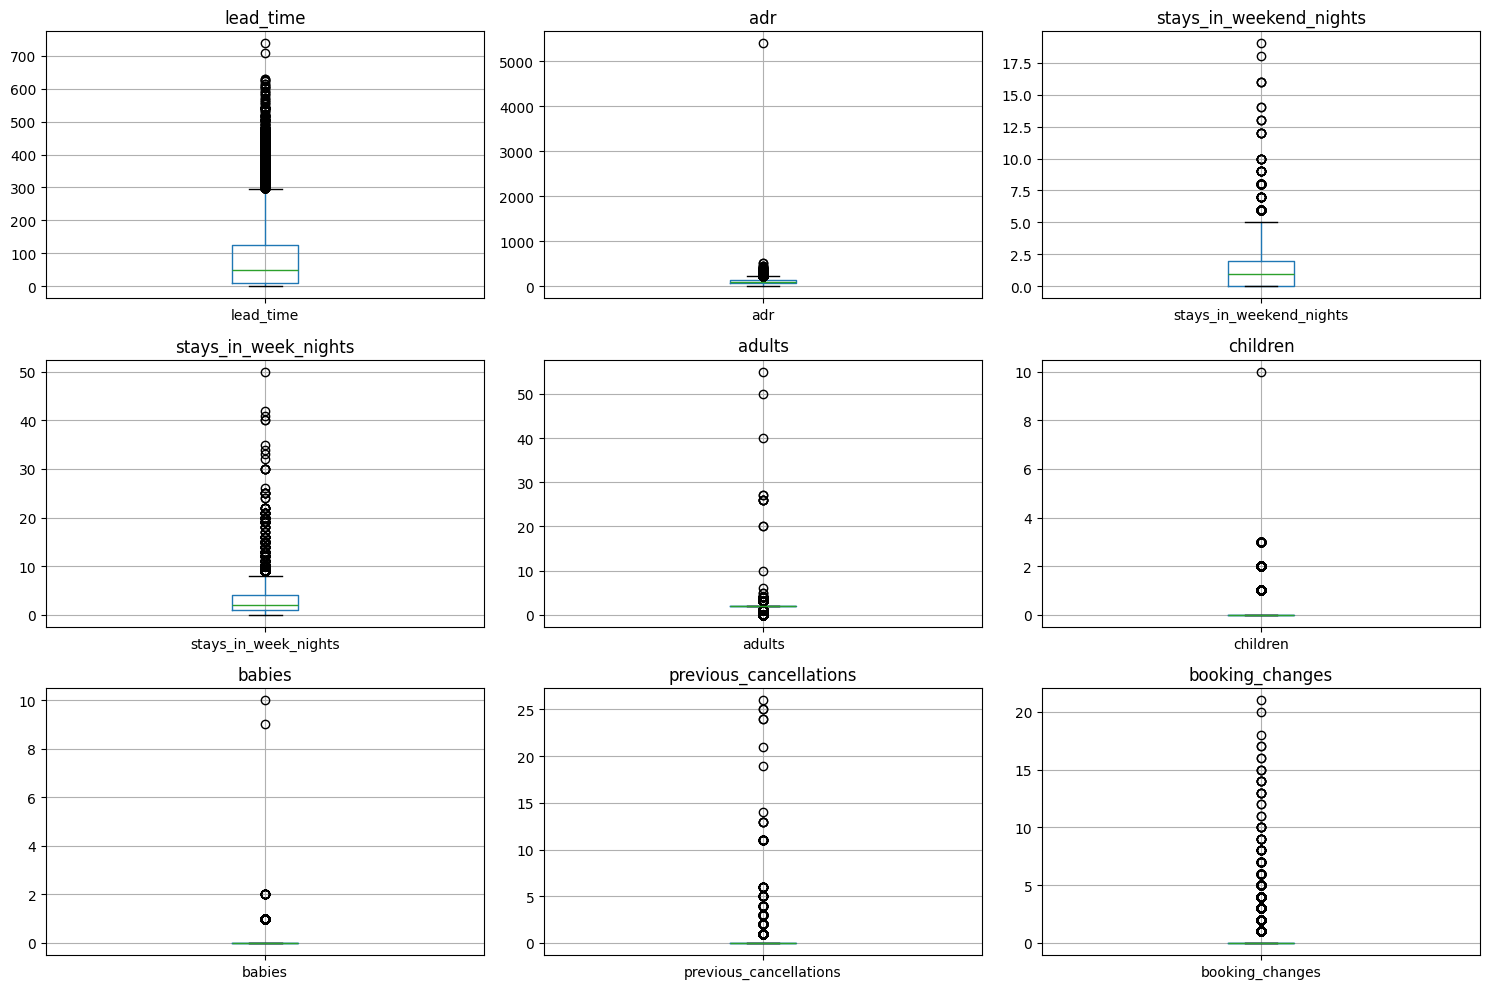

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = ['lead_time', 'adr', 'stays_in_weekend_nights', 
                  'stays_in_week_nights', 'adults', 'children', 'babies',
                  'previous_cancellations', 'booking_changes', 'days_in_waiting_list']

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(numerical_cols[:9]):
    if col in df.columns:
        df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'{col}')

plt.tight_layout()
plt.show()

## Using IQR

In [16]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return {
        'column': column,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_count': len(outliers),
        'outliers_percentage': (len(outliers) / len(df)) * 100,
        'outlier_values': outliers[column].tolist() if len(outliers) > 0 else []
    }

columns_to_check = ['lead_time', 'adr', 'stays_in_week_nights', 
                    'adults', 'children', 'babies',
                    'previous_cancellations', 'booking_changes']

print("IQR OUTLIER ANALYSIS")
print("="*70)

results = {}
for col in columns_to_check:
    if col in df.columns:
        result = detect_outliers_iqr(df, col)
        results[col] = result
        
        print(f"\n{col.upper()}:")
        print(f"  Q1: {result['Q1']:.2f}, Q3: {result['Q3']:.2f}, IQR: {result['IQR']:.2f}")
        print(f"  Bounds: [{result['lower_bound']:.2f}, {result['upper_bound']:.2f}]")
        print(f"  Outliers: {result['outliers_count']:,} ({result['outliers_percentage']:.2f}%)")
        if result['outliers_count'] > 0:
            print(f"  Outlier range: [{min(result['outlier_values']):.2f}, {max(result['outlier_values']):.2f}]")

IQR OUTLIER ANALYSIS

LEAD_TIME:
  Q1: 11.00, Q3: 125.00, IQR: 114.00
  Bounds: [-160.00, 296.00]
  Outliers: 2,396 (2.74%)
  Outlier range: [297.00, 737.00]

ADR:
  Q1: 72.00, Q3: 134.00, IQR: 62.00
  Bounds: [-21.00, 227.00]
  Outliers: 2,490 (2.85%)
  Outlier range: [227.06, 5400.00]

STAYS_IN_WEEK_NIGHTS:
  Q1: 1.00, Q3: 4.00, IQR: 3.00
  Bounds: [-3.50, 8.50]
  Outliers: 1,531 (1.75%)
  Outlier range: [9.00, 50.00]

ADULTS:
  Q1: 2.00, Q3: 2.00, IQR: 0.00
  Bounds: [2.00, 2.00]
  Outliers: 22,894 (26.20%)
  Outlier range: [0.00, 55.00]

CHILDREN:
  Q1: 0.00, Q3: 0.00, IQR: 0.00
  Bounds: [0.00, 0.00]
  Outliers: 8,364 (9.57%)
  Outlier range: [1.00, 10.00]

BABIES:
  Q1: 0.00, Q3: 0.00, IQR: 0.00
  Bounds: [0.00, 0.00]
  Outliers: 914 (1.05%)
  Outlier range: [1.00, 10.00]

PREVIOUS_CANCELLATIONS:
  Q1: 0.00, Q3: 0.00, IQR: 0.00
  Bounds: [0.00, 0.00]
  Outliers: 1,685 (1.93%)
  Outlier range: [1.00, 26.00]

BOOKING_CHANGES:
  Q1: 0.00, Q3: 0.00, IQR: 0.00
  Bounds: [0.00, 0.00]
 

### Capping outliers (ceiling, floor)

In [17]:
def smart_capping_hotel_data(df):
    df_clean = df.copy()
    
    print("SMART CAPPING APPLIED:")
    print("="*60)
    
    lead_upper = df['lead_time'].quantile(0.98)
    df_clean['lead_time'] = np.clip(df['lead_time'], 0, lead_upper)
    print(f"lead_time: [{df['lead_time'].min():.1f}, {df['lead_time'].max():.1f}] → "
          f"[{df_clean['lead_time'].min():.1f}, {df_clean['lead_time'].max():.1f}]")
    
    adr_upper = df['adr'].quantile(0.995)
    adr_lower = max(0, df['adr'].quantile(0.005))  
    df_clean['adr'] = np.clip(df['adr'], adr_lower, adr_upper)
    print(f"adr: [{df['adr'].min():.1f}, {df['adr'].max():.1f}] → "
          f"[{df_clean['adr'].min():.1f}, {df_clean['adr'].max():.1f}]")
    
    week_nights_upper = 30
    df_clean['stays_in_week_nights'] = np.clip(df['stays_in_week_nights'], 0, week_nights_upper)
    print(f"stays_in_week_nights: [{df['stays_in_week_nights'].min():.1f}, "
          f"{df['stays_in_week_nights'].max():.1f}] → "
          f"[{df_clean['stays_in_week_nights'].min():.1f}, "
          f"{df_clean['stays_in_week_nights'].max():.1f}]")
    
    adults_lower = 1 
    adults_upper = 6 
    df_clean['adults'] = np.clip(df['adults'], adults_lower, adults_upper)
    print(f"adults: [{df['adults'].min():.1f}, {df['adults'].max():.1f}] → "
          f"[{df_clean['adults'].min():.1f}, {df_clean['adults'].max():.1f}]")
    
    babies_upper = 3
    df_clean['babies'] = np.clip(df['babies'], 0, babies_upper)
    print(f"babies: [{df['babies'].min():.1f}, {df['babies'].max():.1f}] → "
          f"[{df_clean['babies'].min():.1f}, {df_clean['babies'].max():.1f}]")
    
    children_upper = 4
    df_clean['children'] = np.clip(df['children'], 0, children_upper)
    print(f"children: [{df['children'].min():.1f}, {df['children'].max():.1f}] → "
          f"[{df_clean['children'].min():.1f}, {df_clean['children'].max():.1f}]")
    
    prev_cancel_upper = 10  # Maximum 10 previous cancellations
    df_clean['previous_cancellations'] = np.clip(df['previous_cancellations'], 0, prev_cancel_upper)
    print(f"previous_cancellations: [{df['previous_cancellations'].min():.1f}, "
          f"{df['previous_cancellations'].max():.1f}] → "
          f"[{df_clean['previous_cancellations'].min():.1f}, "
          f"{df_clean['previous_cancellations'].max():.1f}]")
    
    # 8. BOOKING CHANGES - More reasonable cap
    booking_changes_upper = 5  # Maximum 5 changes
    df_clean['booking_changes'] = np.clip(df['booking_changes'], 0, booking_changes_upper)
    print(f"booking_changes: [{df['booking_changes'].min():.1f}, "
          f"{df['booking_changes'].max():.1f}] → "
          f"[{df_clean['booking_changes'].min():.1f}, "
          f"{df_clean['booking_changes'].max():.1f}]")
    
    return df_clean

df_smart_capped = smart_capping_hotel_data(df)

SMART CAPPING APPLIED:
lead_time: [0.0, 737.0] → [0.0, 315.0]
adr: [-6.4, 5400.0] → [0.0, 285.0]
stays_in_week_nights: [0.0, 50.0] → [0.0, 30.0]
adults: [0.0, 55.0] → [1.0, 6.0]
babies: [0.0, 10.0] → [0.0, 3.0]
children: [0.0, 10.0] → [0.0, 4.0]
previous_cancellations: [0.0, 26.0] → [0.0, 10.0]
booking_changes: [0.0, 21.0] → [0.0, 5.0]


### verification

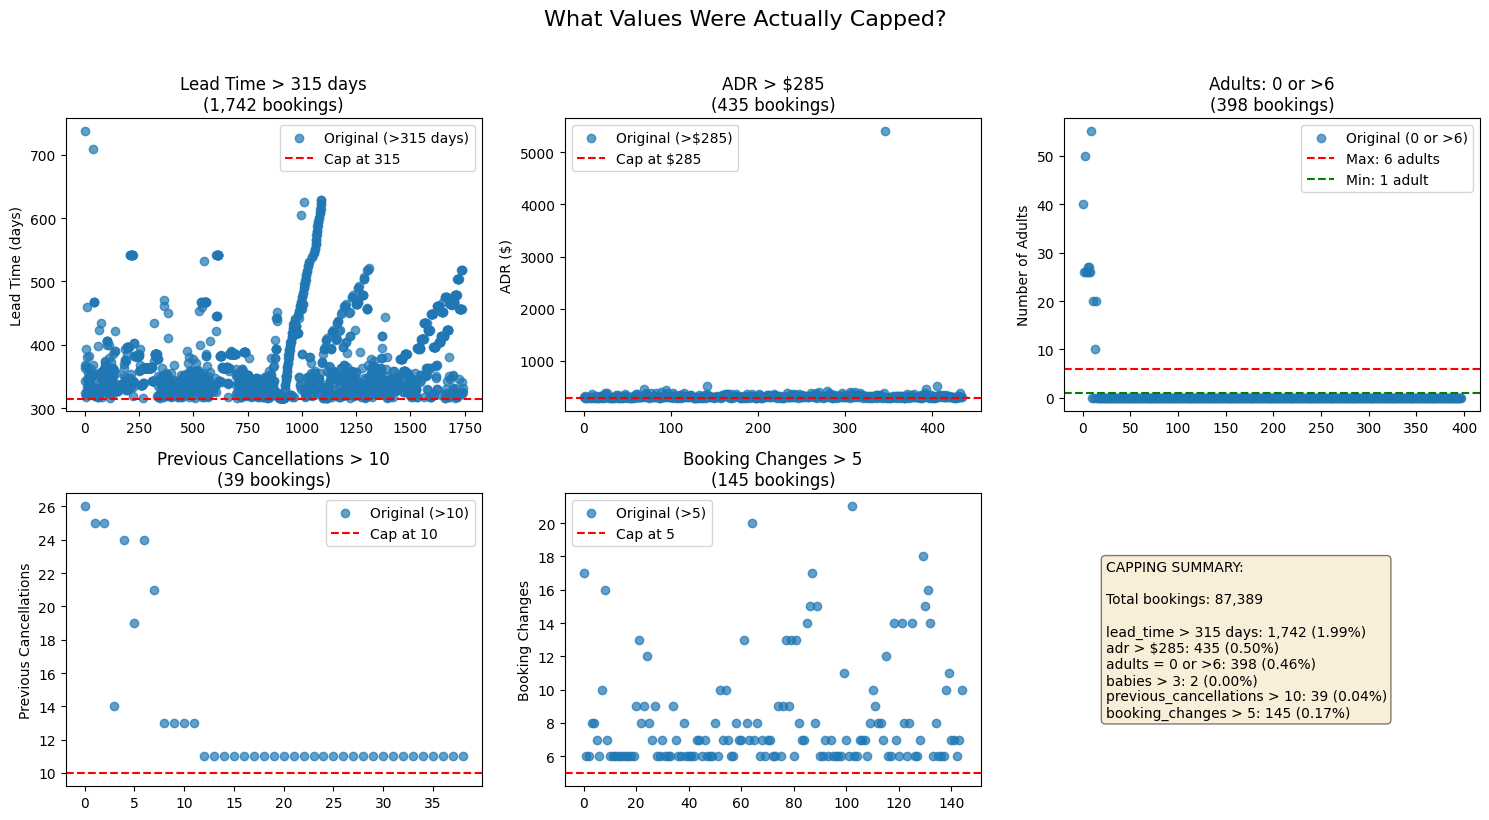

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# 1. Lead Time - Show the capped values
ax = axes[0, 0]
high_lead = df[df['lead_time'] > 315]
ax.scatter(range(len(high_lead)), high_lead['lead_time'], 
          alpha=0.7, label='Original (>315 days)')
ax.axhline(y=315, color='red', linestyle='--', label='Cap at 315')
ax.set_title(f'Lead Time > 315 days\n({len(high_lead):,} bookings)')
ax.set_ylabel('Lead Time (days)')
ax.legend()

# 2. ADR - Show high ADR values
ax = axes[0, 1]
high_adr = df[df['adr'] > 285]
ax.scatter(range(len(high_adr)), high_adr['adr'], 
          alpha=0.7, label='Original (>$285)')
ax.axhline(y=285, color='red', linestyle='--', label='Cap at $285')
ax.set_title(f'ADR > $285\n({len(high_adr):,} bookings)')
ax.set_ylabel('ADR ($)')
ax.legend()

# 3. Adults - Show problematic values
ax = axes[0, 2]
problem_adults = df[(df['adults'] == 0) | (df['adults'] > 6)]
ax.scatter(range(len(problem_adults)), problem_adults['adults'], 
          alpha=0.7, label='Original (0 or >6)')
ax.axhline(y=6, color='red', linestyle='--', label='Max: 6 adults')
ax.axhline(y=1, color='green', linestyle='--', label='Min: 1 adult')
ax.set_title(f'Adults: 0 or >6\n({len(problem_adults):,} bookings)')
ax.set_ylabel('Number of Adults')
ax.legend()

# 4. Previous Cancellations
ax = axes[1, 0]
high_cancels = df[df['previous_cancellations'] > 10]
ax.scatter(range(len(high_cancels)), high_cancels['previous_cancellations'], 
          alpha=0.7, label='Original (>10)')
ax.axhline(y=10, color='red', linestyle='--', label='Cap at 10')
ax.set_title(f'Previous Cancellations > 10\n({len(high_cancels):,} bookings)')
ax.set_ylabel('Previous Cancellations')
ax.legend()

# 5. Booking Changes
ax = axes[1, 1]
many_changes = df[df['booking_changes'] > 5]
ax.scatter(range(len(many_changes)), many_changes['booking_changes'], 
          alpha=0.7, label='Original (>5)')
ax.axhline(y=5, color='red', linestyle='--', label='Cap at 5')
ax.set_title(f'Booking Changes > 5\n({len(many_changes):,} bookings)')
ax.set_ylabel('Booking Changes')
ax.legend()

# 6. Summary Table
ax = axes[1, 2]
ax.axis('off')  

summary_text = "CAPPING SUMMARY:\n\n"
summary_text += f"Total bookings: {len(df):,}\n\n"
summary_text += f"lead_time > 315 days: {len(high_lead):,} ({len(high_lead)/len(df)*100:.2f}%)\n"
summary_text += f"adr > $285: {len(high_adr):,} ({len(high_adr)/len(df)*100:.2f}%)\n"
summary_text += f"adults = 0 or >6: {len(problem_adults):,} ({len(problem_adults)/len(df)*100:.2f}%)\n"
summary_text += f"babies > 3: {(df['babies'] > 3).sum():,} ({(df['babies'] > 3).sum()/len(df)*100:.2f}%)\n"
summary_text += f"previous_cancellations > 10: {len(high_cancels):,} ({len(high_cancels)/len(df)*100:.2f}%)\n"
summary_text += f"booking_changes > 5: {len(many_changes):,} ({len(many_changes)/len(df)*100:.2f}%)"

ax.text(0.1, 0.5, summary_text, fontsize=10, 
        verticalalignment='center', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('What Values Were Actually Capped?', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Saving Clean Dataset

In [19]:
df_smart_capped.to_pickle('hotel_bookings_cleaned.pkl')